Using the data from last class (regression_data.csv), try the find the best combination of preprocessing and model parameters to set the best model based on their basic metrics, MSE and R2. In the notebook, add a markdown to explain the different processes you have applied.

In [12]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import math
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('regression_data1.txt')
data.head()

,HV1,IC1,IC2,IC3,IC4,IC5,AVGGIFT,TARGET_D
0,2346,420,446,468,503,14552,15.500000,21.0
1,497,350,364,357,384,11696,3.080000,3.0
2,1229,469,502,507,544,17313,7.500000,20.0
3,325,148,181,171,209,6334,6.700000,5.0
4,768,174,201,220,249,7802,8.785714,10.0


In [5]:
data.shape

(4843, 8)

# From previous lessons

## R2 and MSE

In [9]:
y = data['TARGET_D']
X = data.drop(['TARGET_D'], axis=1)

X = sm.add_constant(X)
model = sm.OLS(y,X).fit()

# MSE
residuals = model.resid
mse = np.mean(residuals**2)
print(f'MSE: {mse:.2f}')

MSE: 112.71


In [10]:
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
print(f"R2: {round(lm.score(X, y), 3)}")

R2: 0.272


The results are not good... We haven't treated the variables, let's take a general look with a heatmap

<Axes: >

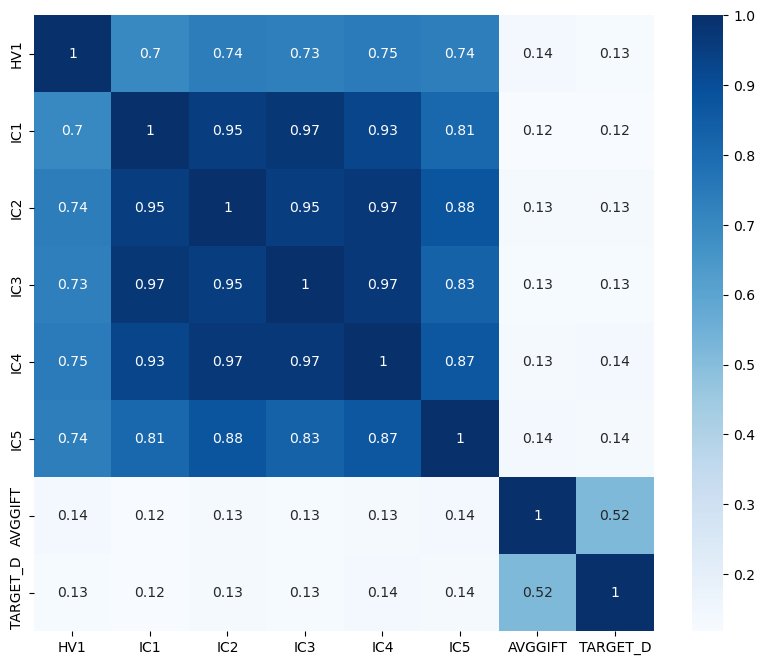

In [ ]:
# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),
            annot=True, 
            cmap='Blues'
            )

The ``IC`` variables have a really high correlation with each other, meaning we have a problem of collinearity. 

## VIF

Let's take a look at the VIF (Variance Inflation Factor) so we can see if there is multicollinearity.

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
vif_data = pd.DataFrame()
vif_data['Variables'] = data.columns
vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif_data

,Variables,VIF
0,HV1,5.132969
1,IC1,278.050431
2,IC2,270.744404
3,IC3,638.040583
4,IC4,535.404193
5,IC5,19.312516
6,AVGGIFT,3.179431
7,TARGET_D,3.431505


As we suspected, we have a problem, VIF can be maximum 10. We apply the following function to get rid one by one of the variable with the highest VIF.

In [21]:
def calcular_vif(data):
    """Calcula el VIF para cada variable en el DataFrame."""
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

def eliminar_variables_vif(data, umbral=10):
    """
    Elimina las variables con el mayor VIF de forma iterativa 
    hasta que todas las variables tengan un VIF inferior al umbral.
    """
    iteracion = 1
    while True:
        print(f"\n--- Iteración {iteracion} ---")
        

        vif_data = calcular_vif(data)
        print(vif_data)
        
        max_vif = vif_data["VIF"].max()
        if max_vif < umbral:
            print("\n✅ Todas las variables tienen VIF menor que", umbral)
            break
        

        variable_a_eliminar = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
        print(f"\n⚠️ Se eliminará la variable con mayor VIF: {variable_a_eliminar} (VIF={max_vif})")
        
        data = data.drop(columns=[variable_a_eliminar])
        
        iteracion += 1
        
    print("\n📊 Proceso finalizado. Variables restantes:")
    print(data.columns)
    return data, vif_data

data_final, vif_final = eliminar_variables_vif(data, umbral=10)


--- Iteración 1 ---
   Variable       VIF
0       HV1  4.333231
1       IC1  5.819806
2   AVGGIFT  3.123332
3  TARGET_D  3.315258

✅ Todas las variables tienen VIF menor que 10

📊 Proceso finalizado. Variables restantes:
Index(['HV1', 'IC1', 'AVGGIFT', 'TARGET_D'], dtype='object')


We got rid of all the ``IC`` except ``IC1``.

In [22]:
data_final

,HV1,IC1,AVGGIFT,TARGET_D
0,2346,420,15.500000,21.0
1,497,350,3.080000,3.0
2,1229,469,7.500000,20.0
3,325,148,6.700000,5.0
4,768,174,8.785714,10.0
...,...,...,...,...
4838,701,297,15.500000,25.0
4839,3357,284,11.857143,19.0
4840,700,322,11.333333,10.0
4841,601,206,13.000000,25.0


In [23]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HV1       4843 non-null   int64  
 1   IC1       4843 non-null   int64  
 2   AVGGIFT   4843 non-null   float64
 3   TARGET_D  4843 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 151.5 KB


So we are left with only numerical variables

# Numerical preprocessing

In [24]:
numericals = data_final.copy()

Let's check if we have null values

In [25]:
numericals.isna().sum()

HV1         0
IC1         0
AVGGIFT     0
TARGET_D    0
dtype: int64

## Outliers

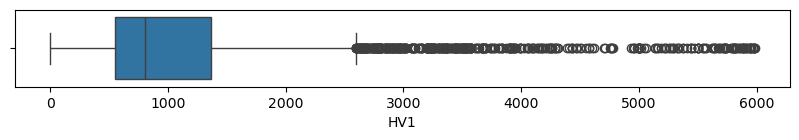

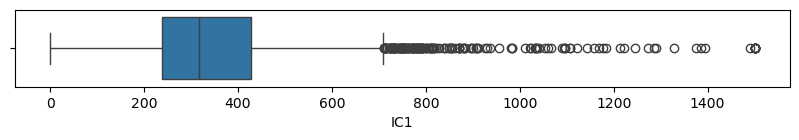

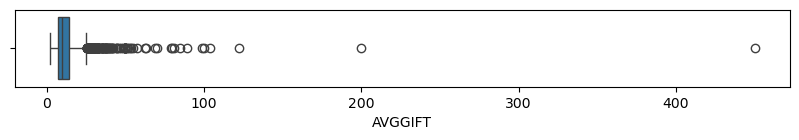

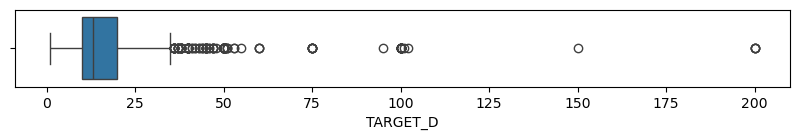

In [30]:
for column in numericals.columns:
    plt.figure(figsize=(10,1))
    sns.boxplot(data=numericals, x=column)
    plt.show()

We have many outliers in the upper end, especially in ``AVGGIFT`` and ``TARGET_D``, meaning they are positively skewed.

We can apply one of 2 transformations: logaritmic and squared.

### ``AVGGIFT`` transformation

#### Logaritmic transformation

In [39]:
# we create a function
def log_trans(x):
    if np.isfinite(x) and x!=0: 
        return np.log(x)
    else:
        return np.NAN # we transform the negatives and 0 values to nan so we can transform them later comfortably

<Axes: >

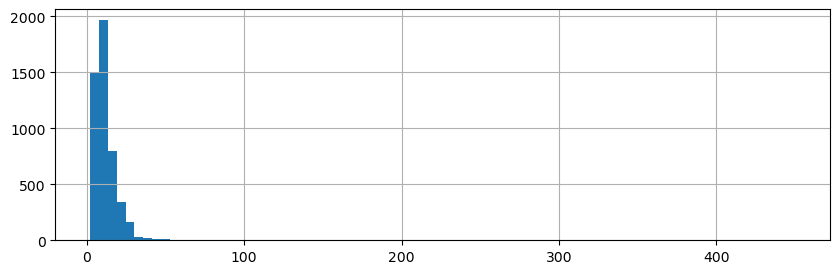

In [44]:
plt.figure(figsize=(10,3))
numericals['AVGGIFT'].hist(bins=80)

<Axes: >

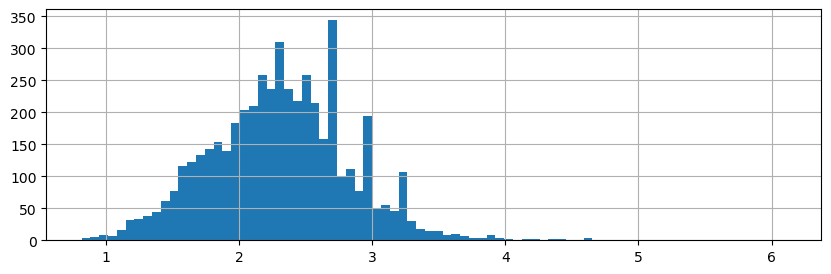

In [45]:
plt.figure(figsize=(10,3))
pd.Series(map(log_trans, numericals['AVGGIFT'])).hist(bins=80)

#### Square root transformation

In [47]:
def squared(x):
    if np.isfinite and x >= 0:
        return np.sqrt(x)
    else:
        return np.NAN

<Axes: >

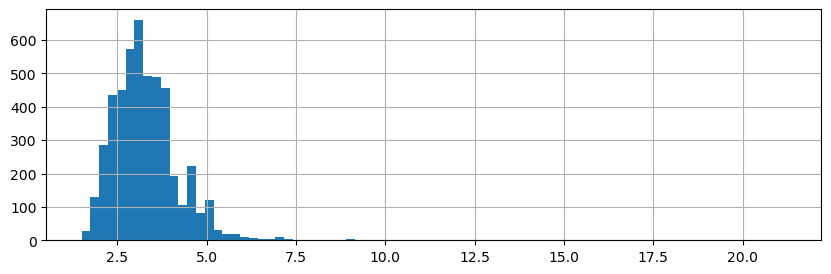

In [48]:
plt.figure(figsize=(10,3))
pd.Series(map(squared, numericals['AVGGIFT'])).hist(bins=80)

# Checking the quality of the model

In [31]:
y = numericals['TARGET_D']
X = numericals.drop(['TARGET_D'], axis=1)

X = sm.add_constant(X)
model = sm.OLS(y,X).fit()

# MSE
residuals = model.resid
mse = np.mean(residuals**2)
print(f'MSE: {mse:.2f}')

MSE: 112.92


In [32]:
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
print(f"R2: {round(lm.score(X, y), 3)}")

R2: 0.271


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

In [34]:
r2

-1.2545663738961212

In [35]:
mse

327.0013615339282